In [1]:
import torch, torchvision
import detectron2

from detectron2.utils.logger import setup_logger

import numpy as np
import cv2
import random
import glob
import torch
import time
import pickle
import os

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import detection_utils as utils
from detectron2.data import samplers
from detectron2.data import build_detection_test_loader

from torch.utils.data import Dataset, DataLoader

geladas_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(geladas_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(
    os.path.join(local_paths["general_dection_path"],
                 "detectron2_classes"
                )
)

from DetectionDatasetMapper import DetectionDatasetMapper

In [2]:
detectron2.__version__

'0.2.1'

In [3]:
# class PredictDataset(Dataset):
    
#     def __init__(self, image_files, image_format):
#         self.image_files = image_files
#         self.img_format = image_format
        
#     def __len__(self):
#         return len(self.image_files)
    
#     def __getitem__(self, idx):
#         image = utils.read_image(self.image_files[idx], 
#                                  format=self.img_format)
#         image_raw = cv2.imread(self.image_files[idx])
#         image = torch.as_tensor(image_raw.astype("float32").transpose(2, 0, 1)).contiguous()
#         image_dict = {"image": image}
#         return image_dict

In [4]:
# from detectron2.data.datasets import register_coco_instances

# # CAN BE ANY BABOON .json ANNOTATION FILE

# register_coco_instances("train", {}, 
#                         "/home/golden/kenya_drones/night_baboons/annotations/original-annotations/train.json", 
#                         "/home/golden/kenya_drones/night_baboons/annotations/original-annotations/images")

# train_metadata = MetadataCatalog.get("train")

In [5]:
models_folder = os.path.join(os.path.dirname(os.getcwd()), 
                             'model_training', 'output')
model_name = "LRscheduler-cropped-color-aug_maxiter-6400_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8"
yaml_file = os.path.join(models_folder, model_name, 'config.yaml')

cfg = get_cfg()

with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)

cfg.INPUT.CROP.ENABLED = False

weights_path = sorted(
    glob.glob(os.path.join(models_folder, model_name, 
                           "best-model-config-iter-*.pth"))
)
cfg.MODEL.WEIGHTS = os.path.join(weights_path[-1])

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

In [6]:
def load_inference_instances(image_files):
    """ Use all given files to make Detectron2 format list of dicts."""
    dataset_dicts = []
    for image_file in image_files:
        record = {"file_name": image_file}
        dataset_dicts.append(record)
    return dataset_dicts

def register_inference_instances(name, image_files):
    """ Register dataset to use for inference. 
    
    Only image file paths are used.
    
    Args:
        name: name of Dataset
        image_files: list of image_files
    """
    DatasetCatalog.register(name, lambda: load_inference_instances(image_files))


In [7]:
# FOLDER THAT HAS THE IMAGES YOU WANT TO PROCESS
video_name = "DJI_0205"
images_folder = local_paths["base_gelada"]

# ---------------------------------------

glob_string = os.path.join(images_folder, "frames", video_name, "*.jpg")
image_files = sorted(glob.glob(glob_string))

print(f"Processing {len(image_files)} frames.")

# dataset = PredictDataset(image_files, cfg.INPUT.FORMAT)

save_root = os.path.join(images_folder, "processing", video_name)
os.makedirs(save_root, exist_ok=True)

Processing 9022 frames.


In [8]:
register_inference_instances("inference", image_files)
mapper = DetectionDatasetMapper(cfg, is_train=False)
loader = build_detection_test_loader(cfg, "inference", mapper=mapper)

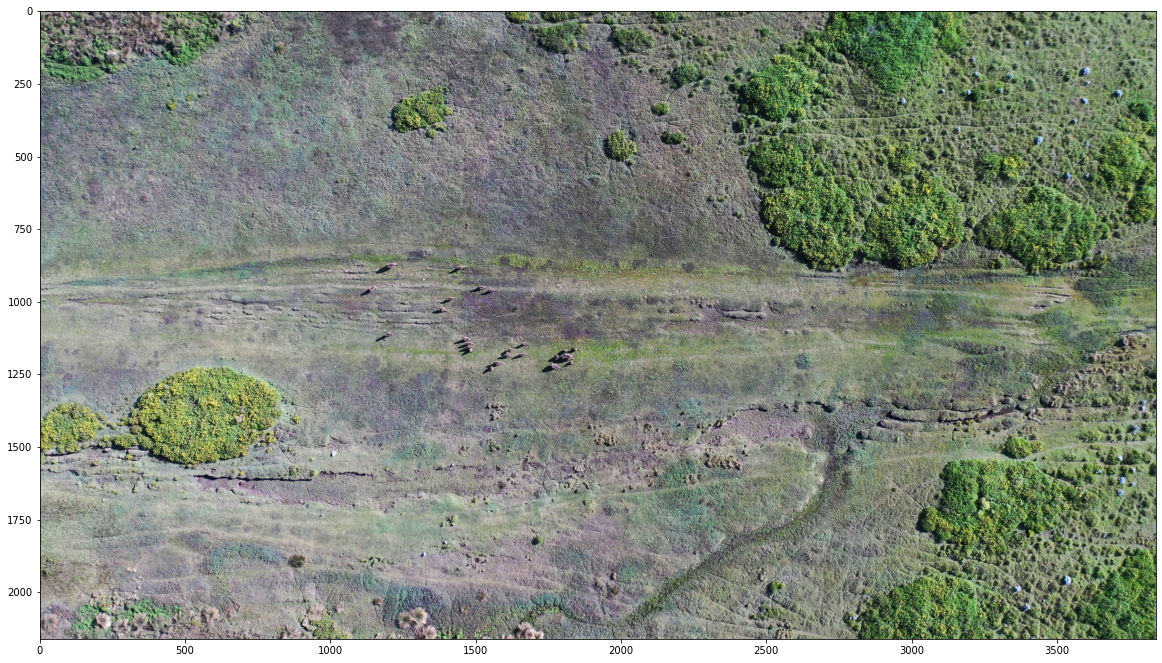

In [9]:
import matplotlib.pyplot as plt
for batch in loader:
    image = batch[0]['image'].numpy()
    image = np.transpose(image, [1, 2, 0])
    plt.figure(figsize=(20, 20))
    plt.imshow(image[..., ::-1].astype(np.uint8))
    break

In [10]:
model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)

In [33]:
import pickle
import os

max_batches = 3600

all_detections = []

t = time.time()
with torch.no_grad():
    for batch_num, image_batch in enumerate(loader):
        if batch_num >= max_batches:
            break
            
        if batch_num % 500 == 0:
            print(f"{batch_num} images processed.")
#         for i in range(len(image_batch)):
#             image_batch[i]['image'] = np.squeeze(image_batch[i]['image'])

#             image_batch[i]['image'] = image_batch[i]['image'].to(cuda0)
#             image_batch[i]['width'] = image_batch[i]['width'].to(cuda0).item()
#             image_batch[i]['height'] = image_batch[i]['height'].to(cuda0).item()
#         print(image_batch['image'].shape)
#         print(image_batch)
        detections = model(image_batch)
#         for preds, im_dict in zip(predictions, image_batch):
#             name = os.path.splitext(os.path.basename(im_dict['file_name'][0]))[0]
#             file = os.path.join(save_root, '{}-predictions.pkl'.format(name))
#             preds_instance = preds["instances"].to("cpu")
#             with open(file, 'wb') as out:
#                 pickle.dump(preds_instance, out)
#                 out.close()



        detection_dict = detections[0]['instances'].get_fields()
        detection_dict['pred_boxes'] = detection_dict['pred_boxes'].tensor.cpu().numpy()
        detection_dict['scores'] = detection_dict['scores'].cpu().numpy()
        detection_dict['pred_classes'] = detection_dict['pred_classes'].cpu().numpy()
        detection_dict['image_name'] = os.path.basename(image_batch[0]['file_name'])
        all_detections.append(detection_dict)


np_detections_file = os.path.join(save_root, '{}_detections.npy'.format(video_name))
np.save(np_detections_file, all_detections)
            
print(time.time() - t)

0 images processed.
500 images processed.
1000 images processed.
1500 images processed.
2000 images processed.
2500 images processed.
3000 images processed.
3500 images processed.
1426.0987150669098


In [32]:
os.path.basename(image_batch[0]['file_name'])

'DJI_0205_000000.jpg'

In [31]:
image = batch[0]['image'].numpy()
image = np.transpose(image, [1, 2, 0])

v = Visualizer(image,
               metadata=None,
               scale=1.0,
)
v = v.draw_instance_predictions(predictions[0]['instances'].to("cpu"))
plt.figure(figsize=(20,20))
plt.imshow(v.get_image())

NameError: name 'predictions' is not defined

In [80]:
predictions[0]['instances']

IndexError: too many indices for tensor of dimension 2

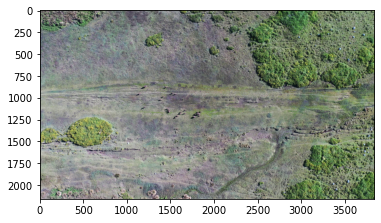

In [44]:
image[0,0]

array([153., 168., 164.], dtype=float32)

In [9]:
# def build_detection_test_loader(cfg, dataset_name, mapper=None):
#     """
#     Similar to `build_detection_train_loader`.
#     But this function uses the given `dataset_name` argument (instead of the names in cfg),
#     and uses batch size 1.
#     Args:
#         cfg: a detectron2 CfgNode
#         dataset_name (str): a name of the dataset that's available in the DatasetCatalog
#         mapper (callable): a callable which takes a sample (dict) from dataset
#            and returns the format to be consumed by the model.
#            By default it will be `DatasetMapper(cfg, False)`.
#     Returns:
#         DataLoader: a torch DataLoader, that loads the given detection
#         dataset, with test-time transformation and batching.
#     """
#     dataset_dicts = get_detection_dataset_dicts(
#         [dataset_name],
#         filter_empty=False,
#         proposal_files=[
#             cfg.DATASETS.PROPOSAL_FILES_TEST[list(cfg.DATASETS.TEST).index(dataset_name)]
#         ]
#         if cfg.MODEL.LOAD_PROPOSALS
#         else None,
#     )

#     dataset = DatasetFromList(dataset_dicts)
#     if mapper is None:
#         mapper = DatasetMapper(cfg, False)
#     dataset = MapDataset(dataset, mapper)

#     sampler = samplers.InferenceSampler(len(dataset))
#     # Always use 1 image per worker during inference since this is the
#     # standard when reporting inference time in papers.
#     batch_sampler = torch.utils.data.sampler.BatchSampler(sampler, 2, drop_last=False)

#     data_loader = torch.utils.data.DataLoader(
#         dataset,
#         num_workers=cfg.DATALOADER.NUM_WORKERS,
#         batch_sampler=batch_sampler,
#         collate_fn=trivial_batch_collator,
#     )
#     return data_loader


# def trivial_batch_collator(batch):
#     """
#     A batch collator that does nothing.
#     """
#     return batch

In [ ]:
data_loader = build_detection_test_loader(cfg, DatasetLabels.VAL)
results = inference_on_dataset(predictor.model, data_loader, evaluator)

In [15]:
batch_size = 2
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=7)

In [16]:
for batch in dataloader:
    print(batch.shape)
    break

AttributeError: 'dict' object has no attribute 'shape'

In [17]:
batch['image'].shape

torch.Size([2, 3, 2160, 3840])

In [18]:
cuda0 = torch.device('cuda:0')

### This is where the actual image inference happens

In [19]:
import pickle
import os

max_batches = 10

t = time.time()
with torch.no_grad():
    for batch_num, image_batch in enumerate(data_loader):
        if batch_num >= max_batches:
            break
            
        if batch_num % 1000 == 0:
            print(f"{batch_num*batch_size} images processed.")
#         for i in range(len(image_batch)):
#             image_batch[i]['image'] = np.squeeze(image_batch[i]['image'])

#             image_batch[i]['image'] = image_batch[i]['image'].to(cuda0)
#             image_batch[i]['width'] = image_batch[i]['width'].to(cuda0).item()
#             image_batch[i]['height'] = image_batch[i]['height'].to(cuda0).item()
#         print(image_batch['image'].shape)
#         print(image_batch)
        predictions = model(image_batch['image'].cuda())
#         for preds, im_dict in zip(predictions, image_batch):
#             name = os.path.splitext(os.path.basename(im_dict['file_name'][0]))[0]
#             file = os.path.join(save_root, '{}-predictions.pkl'.format(name))
#             preds_instance = preds["instances"].to("cpu")
#             with open(file, 'wb') as out:
#                 pickle.dump(preds_instance, out)
#                 out.close()
            
print(time.time() - t)

0 images processed.


IndexError: too many indices for tensor of dimension 3

In [14]:
image_batch

{'image': tensor([[[[153., 147., 142.,  ..., 103.,  89.,  79.],
           [151., 153., 155.,  ...,  99.,  90.,  84.],
           [141., 153., 161.,  ...,  98.,  98., 100.],
           ...,
           [135., 137., 139.,  ...,  84.,  77.,  90.],
           [138., 129., 123.,  ...,  67.,  73.,  86.],
           [128., 127., 132.,  ...,  72.,  88.,  94.]],
 
          [[168., 162., 157.,  ..., 152., 138., 128.],
           [166., 168., 170.,  ..., 148., 139., 133.],
           [156., 168., 176.,  ..., 147., 147., 149.],
           ...,
           [142., 144., 146.,  ..., 124., 118., 134.],
           [147., 138., 132.,  ..., 104., 114., 127.],
           [139., 138., 141.,  ..., 109., 127., 135.]],
 
          [[164., 158., 153.,  ..., 138., 124., 114.],
           [162., 164., 166.,  ..., 134., 125., 119.],
           [152., 164., 172.,  ..., 131., 131., 133.],
           ...,
           [151., 153., 155.,  ...,  96.,  90., 105.],
           [156., 147., 141.,  ...,  78.,  87., 100.],
  

### Below is some stuff to dig into the output

In [15]:
type(predictions[0]['instances'])

detectron2.structures.instances.Instances

In [13]:
import os
name = image_batch[0]['file_name'][0].split('/')[-2]

In [14]:
name

'200311_bifur_05_bottle_third'

In [15]:
# file = os.path.join(save_root, '{}-predictions.pkl'.format(name))
# preds = predictions[0]["instances"].to("cpu")
# with open(file, 'wb') as out:
#     pickle.dump(preds, out)
#     out.close()

In [16]:
files = sorted(glob.glob(os.path.join(save_root, '*-predictions.pkl')))

all_detections = []
raw_instances = []

for file in files[:]:
    with open(file, 'rb') as readfile:
        detections=pickle.load(readfile)
    detection_dict = detections.get_fields()
    detection_dict['pred_boxes'] = detection_dict['pred_boxes'].tensor.numpy()
    detection_dict['scores'] = detection_dict['scores'].numpy()
    detection_dict['pred_classes'] = detection_dict['pred_classes'].numpy()
    detection_dict['image_name'] = os.path.basename(file).split('-')[0]
    all_detections.append(detection_dict)
    raw_instances.append(detections)

np_detections_file = os.path.join(save_root, '{}_detections.npy'.format(name))
np.save(np_detections_file, all_detections)


In [32]:
raw_instances[0]

Instances(num_instances=54, image_height=2160, image_width=3840, fields=[pred_boxes = [[1111.3761    480.6325   1142.183     505.26984 ]
 [1492.2156   1016.1983   1525.7317   1049.0851  ]
 [1375.8276   1133.1849   1403.0193   1165.3248  ]
 [2397.7668    812.44073  2421.534     851.20026 ]
 [ 971.73395   710.4168   1010.99786   743.6545  ]
 [1461.4629    817.90155  1490.4392    850.95355 ]
 [1502.9917   1159.6661   1531.696    1194.6708  ]
 [1689.8596    377.82855  1715.1304    425.8797  ]
 [ 916.50226  1458.8008    948.62384  1488.7947  ]
 [ 866.3059   1506.1677    891.55237  1526.313   ]
 [2183.1543    960.0635   2208.4526    986.7738  ]
 [2420.9966    491.01846  2467.9888    516.83276 ]
 [ 622.02045  1210.973     652.77045  1243.2089  ]
 [1773.9891    449.04755  1795.8192    486.46356 ]
 [ 783.19464  1496.3099    805.9832   1514.0253  ]
 [2494.6265    792.689    2513.229     822.18024 ]
 [1568.1029    551.9051   1591.0521    588.58356 ]
 [2069.5757    747.5669   2090.5674    781.6253

In [16]:
import numpy as np
import glob

files = [np_detections_file]


for file in files[0:1]:
    detections = np.load(file, allow_pickle=True)
    print(detections[100]['scores'].shape)
    print(detections[100]['image_name'])

(44,)
200311_bifur_05_bottle_third_00100


In [30]:
# image_files = glob.glob(images_folder + '/*.jpg')

In [21]:
# detections

In [21]:
files[0]

'/home/golden/kenya_drones/kenya-locusts/frames/200311_bifur_05_bottle_third/200311_bifur_05_bottle_third_00000.jpg'

In [20]:
import matplotlib.pyplot as plt
im_ind = 0
images_folder
files = sorted(glob.glob(images_folder + '/*.jpg'))
im = plt.imread(files[0])
print(im.shape)

(2160, 3840, 3)


In [22]:
import matplotlib.pyplot as plt

make_video = True
draw_plots = False
max_frames = 5000
fps = 30
output_file = '/home/golden/Dropbox/locusts/test_video_full.mp4'

if make_video:
    frames = 0
    out = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, (3840, 2160))
    print('here')
    

# for im_ind in np.linspace(0, len(raw_instances)-1, 20, dtype=int):
for im_ind in range(len(raw_instances)):
# for im_ind in range(60):
    if im_ind >= max_frames:
        break
        
    if im_ind % 500 == 0:
        print(im_ind)
    
#     observation_name = raw_instances[im_ind].image_name.split('_')[0] + '_' +  raw_instances[im_ind].image_name.split('_')[1]

#     image_raw = plt.imread(os.path.join(os.path.dirname(images_folder), observation_name, raw_instances[im_ind].image_name + '.jpg'))
    image_raw = plt.imread(files[im_ind])

    v = Visualizer(image_raw,
                   metadata=train_metadata,
                   scale=1.0,
    )
    v = v.draw_instance_predictions(raw_instances[im_ind])
    if make_video:
        out.write(v.get_image()[...,::-1])
        frames += 1
    if draw_plots:
        plt.figure(figsize=(20,20))
        plt.imshow(v.get_image())
if make_video:
    out.release()
    print('num frames {}'.format(frames))

here
0
500
1000
1500
2000
2500
3000
3500
4000
4500
num frames 4850


In [28]:
os.path.exists(output_file)

False

In [22]:
v.get_image()[...,::-1].shape

(2160, 3840, 3)

(2160, 2872, 3)

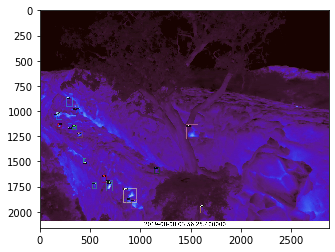

In [34]:
plt.imshow(v.get_image()[...,::-1])
v.get_image().shape

In [26]:
test = np.load(os.path.join(save_root, '{}-predictions.npy'.format(name)), allow_pickle=True)

In [50]:
files = sorted(glob.glob(os.path.join(save_root, '*-predictions.pkl')))
readfile = files[0]
with open(file, 'rb') as readfile:
    detections=pickle.load(readfile)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(
    "/home/golden/detectron2-master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)



cfg.DATASETS.TRAIN = ("salmon-train",)
cfg.DATASETS.TEST = ("salmon-val",)
cfg.DATALOADER.NUM_WORKERS = 6
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.019
cfg.SOLVER.MAX_ITER = (2000)
cfg.SOLVER.WARMUP_ITERS = 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (256)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.TEST.EVAL_PERIOD = 100
cfg.TEST.DETECTIONS_PER_IMAGE = 200


cfg.INPUT.MIN_SIZE_TEST = (0)

cfg.INPUT.MAX_SIZE_TEST = (4000)



In [ ]:
# Check validation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("salmon-val", )
predictor = DefaultPredictor(cfg)

for d in val_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata,
                   scale=1.0,
                   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])